# Modeling the Comment Data for Emotional Sentiment

At this stage, the comment data was ready for use. However, the training data had yet to be prepared. In the first section of this notebook, I imported the training data and prepared it for modeling. 

The models are trained on the NRC Emotion Lexicon, which is a data set compiled by The National Research Council Canada. The NRC is the Government of Canada's largest research organization supporting industrial innovation, the advancement of knowledge and technology development. The Emotion Lexicon Dataset is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing. I used this dataset to train my models, with the goal of teaching a model to understand the emotional associations of various english words. 

Each word in the NRC Emotion Lexicon is annotated by at least two synonyms. The primary terms are then flagged if they have been associated with one of the eight listed emotions, and/or one of the two sentiments. Since the sentiments are more general in nature than the emotions, and since each term could potentially be flagged for more than one emotion/sentiment, I decided to model the sentiments separately as a binary classification regression.

In the case of modeling the emotions, I tried two different approaches. The first apprach was to model all the data together as a multiclass classification, using all 8 emotions as separate target values. However, as you'll see in this notebook, this did not produce reliable results. I did a train-test split of the NRC data and got accuracy scores of 0.6509 for the training set and 0.2382 for the test set. While this was a slight improvement from the baseline accuracy score of 0.1802 for the majority class, I wanted to see if I could achieve better results by running separate binary classifications for each target category (i.e. positive or negative for _anger_). Indeed, this second approach yielded better results - 80th and 90th percentile scores for each target value. In addition, the training models were not as drastically overfit, as indicated by the approximate difference in training and testing scores of about 10 percentage points. 

In [1]:
## Packages and libraries:

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

from apiclient.discovery import build
import api_key as api_key

import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

####  Some notes on the NRC Dataset:

The original lexicon has annotations at word-sense level. Each word-sense pair was annotated by at least three annotators (most are annotated by at least five). 

Each line has the following format:

- **[term]--[NearSynonyms][tab][AffectCategory][tab][AssociationFlag]**

- **[term]** is a word for which emotion associations are provided;

- **[NearSynonyms]** is a set of one to three comma-separated words that indicate the sense of the [term]. The affect annotations are for this sense of the term.

- **[AffectCategory]** is one of eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, or disgust) or one of two polarities (negative or positive);

- **[AssociationFlag]** has one of two possible values: 0 or 1. 0 indicates that the target word has no association with affect category, whereas 1 indicates an association.

In [2]:
word_sense = pd.read_csv('./Data/NRC_Datasets/NRC-Emotion-Lexicon-Senselevel-v0.92.txt', delimiter='\t', header=None)
word_sense[[0,'NearSynonyms']] = word_sense[0].str.split('--',expand=True)
word_sense[['NearSynonyms', 'NearSynonym_1', 'NearSynonym_2', 'NearSynonym_3']] = word_sense['NearSynonyms'].str.split(',',expand=True)
word_sense.columns = ['Term', 'AffectCategory', 'Flag', 'Synonym_1', 'Synonym_2', 'Synonym_3', 'Synonym_4']
word_sense.head()

,Term,AffectCategory,Flag,Synonym_1,Synonym_2,Synonym_3,Synonym_4
0,gut,fear,0,opening,fistula,tubule,None
1,gut,anger,0,opening,fistula,tubule,None
2,gut,anticip,0,opening,fistula,tubule,None
3,gut,trust,0,opening,fistula,tubule,None
4,gut,surprise,0,opening,fistula,tubule,None


In [3]:
word_sense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242060 entries, 0 to 242059
Data columns (total 7 columns):
Term              242060 non-null object
AffectCategory    242060 non-null object
Flag              242060 non-null int64
Synonym_1         242060 non-null object
Synonym_2         91020 non-null object
Synonym_3         91020 non-null object
Synonym_4         200 non-null object
dtypes: int64(1), object(6)
memory usage: 12.9+ MB


In [4]:
word_sense.shape

(242060, 7)

In [5]:
word_sense.drop(['Synonym_4'], axis=1, inplace=True)

In [6]:
target_classes = {'negative': 1, 'positive': 2, 'fear': 3, 'anger': 4, 'trust': 5, 'sadness': 6, 'disgust': 7, 
                  'joy': 8, 'anticip': 9, 'surprise': 10}

word_sense['AffectCategory_Value'] = word_sense['AffectCategory']
word_sense['AffectCategory_Value'].replace(target_classes, inplace=True)

word_sense['Target'] = np.where(word_sense['Flag'] == 1, word_sense['AffectCategory_Value'], 0)

for item in target_classes:
    word_sense[item] = np.where(word_sense['Flag'] == target_classes[item], 1, 0)

In [7]:
word_sense = word_sense[word_sense['Flag'] != 0]

word_sense.head()

,Term,AffectCategory,Flag,Synonym_1,Synonym_2,Synonym_3,AffectCategory_Value,Target,negative,positive,fear,anger,trust,sadness,disgust,joy,anticip,surprise
8,gut,disgust,1,opening,fistula,tubule,7,7,1,0,0,0,0,0,0,0,0,0
26,conceit,negative,1,vanity,assurance,airs,1,1,1,0,0,0,0,0,0,0,0,0
33,guide,trust,1,teaching,direct,breed,5,5,1,0,0,0,0,0,0,0,0,0
35,guide,positive,1,teaching,direct,breed,2,2,1,0,0,0,0,0,0,0,0,0
83,associate,trust,1,friend,colleague,neighbor,5,5,1,0,0,0,0,0,0,0,0,0


In [8]:
word_sense.shape

(19236, 18)

In [9]:
word_sense['Term'] = [(str(x) + ' ') for x in word_sense['Term']]

In [10]:
columns = word_sense[['Term', 'Synonym_1', 'Synonym_2', 'Synonym_3']].astype(str)
features = columns.sum(axis=1)

word_sense['features'] = [(str(x) + ' ') for x in features]
word_sense['features'] = [(str(x).strip('None')) for x in features]

In [11]:
word_sense[word_sense['AffectCategory_Value'] < 3]['AffectCategory'].value_counts(normalize=True)

negative    0.597806
positive    0.402194
Name: AffectCategory, dtype: float64

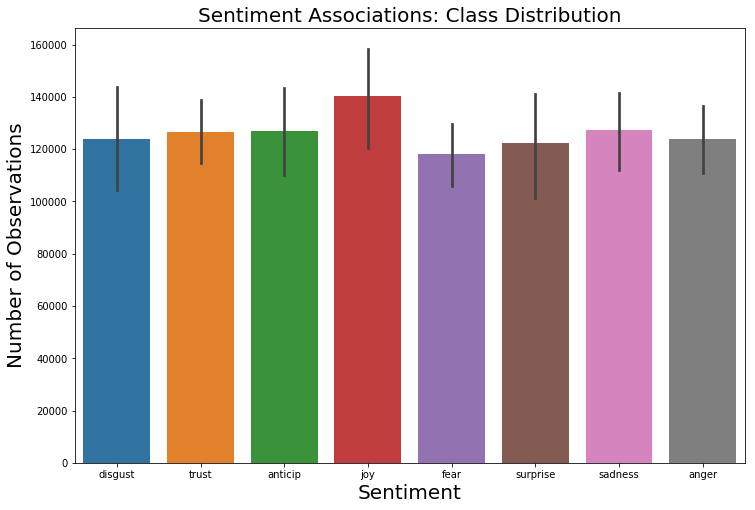

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(word_sense[word_sense['AffectCategory_Value'] >= 3]['AffectCategory'], word_sense.index, ax=ax)
plt.title('Sentiment Associations: Class Distribution', fontsize=20)
plt.xlabel('Sentiment', fontsize=20)
plt.ylabel('Number of Observations', fontsize=20)
# plt.legend({'Neg = 1':1, 'Pos = 2':2 })
plt.show()

## Modeling for Sentiment:

In [13]:
sentiment_df = word_sense[(word_sense['Target'] == 1) | (word_sense['Target'] == 2)]
sentiment_df.head()

,Term,AffectCategory,Flag,Synonym_1,Synonym_2,Synonym_3,AffectCategory_Value,Target,negative,positive,fear,anger,trust,sadness,disgust,joy,anticip,surprise,features
26,conceit,negative,1,vanity,assurance,airs,1,1,1,0,0,0,0,0,0,0,0,0,conceit vanity assurance airs
35,guide,positive,1,teaching,direct,breed,2,2,1,0,0,0,0,0,0,0,0,0,guide teaching direct breed
85,associate,positive,1,friend,colleague,neighbor,2,2,1,0,0,0,0,0,0,0,0,0,associate friend colleague neighbor
106,ignore,negative,1,repudiate,disclaim,abrogate,1,1,1,0,0,0,0,0,0,0,0,0,ignore repudiate disclaim abrogat
136,contravene,negative,1,contradict,rebut,oppose,1,1,1,0,0,0,0,0,0,0,0,0,contravene contradict rebut oppos


In [14]:
sentiment_df['Target'].value_counts(normalize=True)

1    0.597806
2    0.402194
Name: Target, dtype: float64

#### Sentiment Data Train-Test Split

In [15]:
# tvec = TfidfVectorizer(ngram_range=(1, 4), tokenizer=None, max_df=4)

X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(sentiment_df['features'], 
                                                                        sentiment_df['Target'], 
                                                                        random_state=42)

cvec_sent = CountVectorizer(ngram_range=(1, 4), tokenizer=None, max_df=500)

X_sent_train_cvec = cvec_sent.fit_transform(X_sent_train)
X_sent_test_cvec = cvec_sent.transform(X_sent_test)

sentiment_cvec = pd.DataFrame(X_sent_train_cvec.toarray(), columns=cvec_sent.get_feature_names())
sentiment_cvec['target'] = y_sent_train
sentiment_cvec.head()

,ab,ab taking,abandoned,abandoned neglect,abandonment,abandonment dispensation,abandonment dispensation expropriation,abandonment dispensation expropriation riddanc,abandonment expropriati,abandonment hopelessness,...,zealous activity,zer,zero,zero naught,zero naught nought,zest,zest pleasur,zip,zip zer,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [16]:
sentiment_cvec.shape

(6357, 25209)

In [17]:
lr_sentiment = LogisticRegression(random_state=42)

lr_sentiment.fit(X_sent_train_cvec, y_sent_train)

print('Sentiment Train Score: ', lr_sentiment.score(X_sent_train_cvec, y_sent_train))
print('Sentiment Test Score: ', lr_sentiment.score(X_sent_test_cvec, y_sent_test))

Sentiment Train Score:  0.9919773478055687
Sentiment Test Score:  0.8876828692779613


#### Introducing the Comment Data:

In [18]:
comment_data = pd.read_json('./Data/test_data.json', orient='columns')
comment_data.reset_index(inplace=True)
comment_data.drop(['level_0', 'index'], axis=1, inplace=True)
comment_data['published_on'] = [pd.to_datetime(x) for x in comment_data['published_on']]
comment_data.head()

,post_id,published_on,num_comments,likes,score_views,source,title,all_comments
0,kJQP7kiw5Fk,1970-01-01 00:24:44.283602,3035242,31966704,5959601315,Youtube.com,Luis Fonsi - Despacito ft. Daddy Yankee,despacito disponible ya en todas las plataform...
1,JGwWNGJdvx8,1970-01-01 00:24:45.773870,873673,19004938,4066735225,Youtube.com,Ed Sheeran - Shape of You [Official Video],stream or download shape of you: https://atlan...
2,0KSOMA3QBU0,1970-01-01 00:23:12.926403,619270,8274236,2508899649,Youtube.com,Katy Perry - Dark Horse (Official) ft. Juicy J,get dark horse from katy perrys prism: http://...
3,j-sz8M8gc6U,1970-01-01 00:25:16.405364,72034,2018890,474247970,Youtube.com,Ozuna x Bad Bunny x Wisin x Almighty - Solita,solita - ozuna x bad bunny x almighty x wisin...
4,oRdxUFDoQe0,1970-01-01 00:21:42.516813,119552,2423139,473761496,Youtube.com,Michael Jackson - Beat It (Official Video),music video by michael jackson performing beat...


In [19]:
X_comment_test = cvec_sent.transform(comment_data['all_comments'])

comment_cvec_test = pd.DataFrame(X_comment_test.toarray(), columns=cvec_sent.get_feature_names())
comment_cvec_test.head()

,ab,ab taking,abandoned,abandoned neglect,abandonment,abandonment dispensation,abandonment dispensation expropriation,abandonment dispensation expropriation riddanc,abandonment expropriati,abandonment hopelessness,...,zealous,zealous activity,zer,zero,zero naught,zero naught nought,zest,zest pleasur,zip,zip zer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
comment_cvec_test.shape

(651, 25208)

In [21]:
sentiment_preds = lr_sentiment.predict(X_comment_test)

In [22]:
print(lr_sentiment.classes_)
print(lr_sentiment.coef_[0])

[1 2]
[-0.0946769  -0.0946769  -0.1056816  ...  0.11869291 -0.24219056
 -0.24219056]


In [23]:
# lr_words = pd.DataFrame(preds, columns=['class'])
# coef_df = pd.DataFrame(lr.coef_, index=[lr.classes_])
# top_lr_words = [lr_words[0].abs().sort_values(ascending=False)][:30]
len(sentiment_preds)

651

In [24]:
comment_data['predicted_sentiment'] = sentiment_preds

In [25]:
target_classes = {'negative': 1, 'positive': 2, 'fear': 3, 'anger': 4, 'trust': 5, 'sadness': 6, 'disgust': 7, 
                  'joy': 8, 'anticip': 9, 'surprise': 10}

# sentiment_preds_df = test[(test['predicted_class'] == 1) & (test['source'] == 'Youtube.com')]
# sentiment_preds_df.head(10)

print(comment_data['predicted_sentiment'].value_counts())

2    640
1     11
Name: predicted_sentiment, dtype: int64


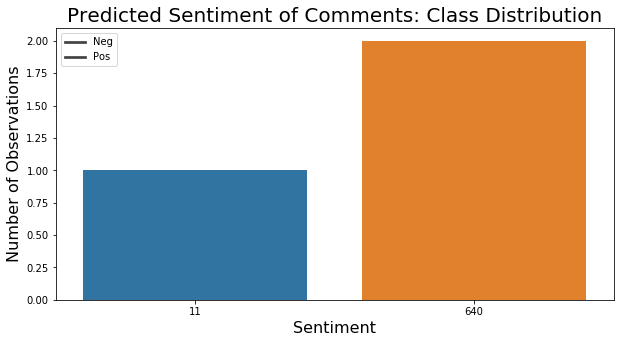

In [26]:
# predictors = df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)
# corr_df = pd.DataFrame(predictors.iloc[1:11])

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(comment_data['predicted_sentiment'].value_counts(), comment_data.index, ax=ax)
plt.title('Predicted Sentiment of Comments: Class Distribution', fontsize=20)
plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Number of Observations', fontsize=16)
plt.legend(['Neg', 'Pos'])
plt.show()

## Modeling for Emotions:

#### Approach #1: Model ALL the data using multiclass classification 

In [27]:
emotion_df = word_sense[word_sense['Target'] > 2]
emotion_df.head()

,Term,AffectCategory,Flag,Synonym_1,Synonym_2,Synonym_3,AffectCategory_Value,Target,negative,positive,fear,anger,trust,sadness,disgust,joy,anticip,surprise,features
8,gut,disgust,1,opening,fistula,tubule,7,7,1,0,0,0,0,0,0,0,0,0,gut opening fistula tubul
33,guide,trust,1,teaching,direct,breed,5,5,1,0,0,0,0,0,0,0,0,0,guide teaching direct breed
83,associate,trust,1,friend,colleague,neighbor,5,5,1,0,0,0,0,0,0,0,0,0,associate friend colleague neighbor
153,association,trust,1,assemblage,shower,brotherhood,5,5,1,0,0,0,0,0,0,0,0,0,association assemblage shower brotherhood
232,triumph,anticip,1,celebration,commemoration,jubilee,9,9,1,0,0,0,0,0,0,0,0,0,triumph celebration commemoration jubil


In [28]:
emotion_df['AffectCategory'].value_counts(normalize=True)

fear        0.180204
anger       0.150836
trust       0.147677
sadness     0.140613
disgust     0.124814
joy         0.102602
anticip     0.094424
surprise    0.058829
Name: AffectCategory, dtype: float64

#### Emotion Data train-test split:

In [29]:
# tvec_emo = TfidfVectorizer(ngram_range=(1, 4), tokenizer=None, max_df=4)

X_emo_train, X_emo_test, y_emo_train, y_emo_test = train_test_split(emotion_df['features'], 
                                                                        emotion_df['Target'], 
                                                                        random_state=42)

cvec_emo = CountVectorizer(ngram_range=(1, 4), tokenizer=None, max_df=500)

X_emo_train_cvec = cvec_emo.fit_transform(X_emo_train)
X_emo_test_cvec = cvec_emo.transform(X_emo_test)

emotion_cvec = pd.DataFrame(X_emo_train_cvec.toarray(), columns=cvec_emo.get_feature_names())
emotion_cvec['target'] = y_emo_train
emotion_cvec.head()

,ab,ab decepti,aband,abandon,abandon avoidance,abandon avoidance fly,abandon avoidance fly fl,abandoned,abandoned neglect,abandoned seclusi,...,zeal resolution energy backb,zealot,zealot enthusiast,zealot hustler,zealous,zealous activity,zest,zest pleasur,zest savoriness,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [30]:
lr_emotion = LogisticRegression(random_state=42)

lr_emotion.fit(X_emo_train_cvec, y_emo_train)

print('Emotion Train Score: ', lr_emotion.score(X_emo_train_cvec, y_emo_train))
print('Emotion Test Score: ', lr_emotion.score(X_emo_test_cvec, y_emo_test))

Emotion Train Score:  0.6509293680297398
Emotion Test Score:  0.2382899628252788


In [31]:
# TRANSFORM COMMENT DATA AGAIN

X_comment_test_emo = cvec_emo.transform(comment_data['all_comments'])

comment_cvec_test_emo = pd.DataFrame(X_comment_test_emo.toarray(), columns=cvec_emo.get_feature_names())
comment_cvec_test_emo.head()

,ab,ab decepti,aband,abandon,abandon avoidance,abandon avoidance fly,abandon avoidance fly fl,abandoned,abandoned neglect,abandoned seclusi,...,zeal resolution energy,zeal resolution energy backb,zealot,zealot enthusiast,zealot hustler,zealous,zealous activity,zest,zest pleasur,zest savoriness
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
emotion_preds = lr_emotion.predict(X_comment_test_emo)

In [33]:
print(lr_emotion.classes_)
print(lr_emotion.coef_[0])

[ 3  4  5  6  7  8  9 10]
[-0.15581206 -0.15581206 -0.06422168 ... -0.22621259 -0.04209625
 -0.18411635]


In [34]:
# lr_words = pd.DataFrame(preds, columns=['class'])
# coef_df = pd.DataFrame(lr.coef_, index=[lr.classes_])
# top_lr_words = [lr_words[0].abs().sort_values(ascending=False)][:30]
len(emotion_preds)

651

In [35]:
comment_data['predicted_emotion'] = emotion_preds

In [36]:
target_classes = {'negative': 1, 'positive': 2, 'fear': 3, 'anger': 4, 'trust': 5, 'sadness': 6, 'disgust': 7, 
                  'joy': 8, 'anticip': 9, 'surprise': 10}

# sentiment_preds_df = test[(test['predicted_class'] == 1) & (test['source'] == 'Youtube.com')]
# sentiment_preds_df.head(10)

comment_data['predicted_emotion'].value_counts(normalize=True)

9     0.855607
5     0.062980
8     0.053763
6     0.013825
4     0.004608
10    0.003072
7     0.003072
3     0.003072
Name: predicted_emotion, dtype: float64

No handles with labels found to put in legend.


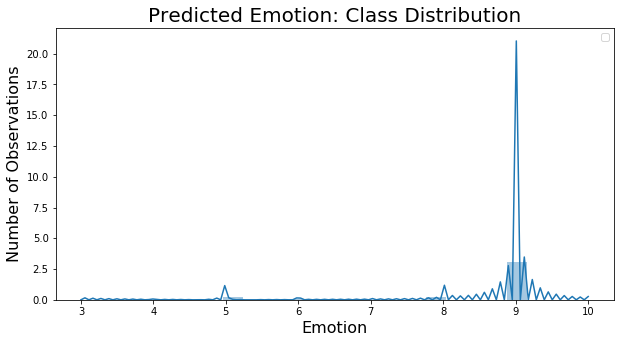

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(comment_data['predicted_emotion'], ax=ax)
plt.title('Predicted Emotion: Class Distribution', fontsize=20)
plt.xlabel('Emotion', fontsize=16)
plt.ylabel('Number of Observations', fontsize=16)
plt.legend()
plt.show()

#### Approach #2: Binary Classification for each affect category

In [38]:
emotion_df['AffectCategory_Value'].value_counts()

3     1939
4     1623
5     1589
6     1513
7     1343
8     1104
9     1016
10     633
Name: AffectCategory_Value, dtype: int64

In [39]:
emotion_df = pd.get_dummies(emotion_df, columns = ['Target'], drop_first=False)
emotion_df.head()

,Term,AffectCategory,Flag,Synonym_1,Synonym_2,Synonym_3,AffectCategory_Value,negative,positive,fear,...,surprise,features,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10
8,gut,disgust,1,opening,fistula,tubule,7,1,0,0,...,0,gut opening fistula tubul,0,0,0,0,1,0,0,0
33,guide,trust,1,teaching,direct,breed,5,1,0,0,...,0,guide teaching direct breed,0,0,1,0,0,0,0,0
83,associate,trust,1,friend,colleague,neighbor,5,1,0,0,...,0,associate friend colleague neighbor,0,0,1,0,0,0,0,0
153,association,trust,1,assemblage,shower,brotherhood,5,1,0,0,...,0,association assemblage shower brotherhood,0,0,1,0,0,0,0,0
232,triumph,anticip,1,celebration,commemoration,jubilee,9,1,0,0,...,0,triumph celebration commemoration jubil,0,0,0,0,0,0,1,0


In [40]:
targets = list(range(3,11))
coefficient_dfs = []

for item in targets:
    
### MODELING PHASE I: Training DataSet ###

    # Train-Test Split:
    X_train, X_test, y_train, y_test = train_test_split(emotion_df['features'], 
                                                        emotion_df['Target_' + str(item)], 
                                                        random_state=42)
    
    
    # Transform the data using CountVectorizer:
    cvec = CountVectorizer(ngram_range=(1, 4), tokenizer=None, max_df=500)

    X_train_cvec = cvec.fit_transform(X_train)
    X_test_cvec = cvec.transform(X_test)
    
    
    # Create DataFrame of vectorized data:
    cvec_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())
    cvec_train_df['target'] = y_train
    
    
    # Model fit & score:
    lr = LogisticRegression(random_state=42)

    lr.fit(X_train_cvec, y_train)

    print('Emotion Train Score, Target_' + str(item) + ':   ', lr.score(X_train_cvec, y_train))
    print('Emotion Test Score, Target_' + str(item) + ':    ', lr.score(X_test_cvec, y_test))
    print('   ')
    

### MODELING PHASE II: Testing DataSet ###

    # Transform the test data using CountVectorizer:
    X_comment_test_cvec = cvec.transform(comment_data['all_comments'])

    
    # Create DataFrame of vectorized data:
    cvec_test_df = pd.DataFrame(X_comment_test_cvec.toarray(), columns=cvec.get_feature_names())
    cvec_test_df.head()
    
    # Model predict:
    comment_preds = lr.predict(X_comment_test_cvec)
    
    
    # Collect coefficients of all featues and append to a list for future reference:
    coef_list = []

    for c, value in list(enumerate(cvec_test_df.columns)):
        coef_list.append([c, value])

    coef_df = pd.DataFrame(coef_list)
    coef_df[str(item) + '_coefficients'] = lr.coef_[0]
    
    coefficient_dfs.append(coef_df)
    
    # Append predictions to the test DataFrame:
    comment_data['Target_' + str(item)] = comment_preds

Emotion Train Score, Target_3:    0.8582403965303593
Emotion Test Score, Target_3:     0.7866171003717473
   
Emotion Train Score, Target_4:    0.8807930607187113
Emotion Test Score, Target_4:     0.8182156133828996
   
Emotion Train Score, Target_5:    0.9313506815365551
Emotion Test Score, Target_5:     0.846096654275093
   
Emotion Train Score, Target_6:    0.8947955390334572
Emotion Test Score, Target_6:     0.8412639405204461
   
Emotion Train Score, Target_7:    0.9017348203221809
Emotion Test Score, Target_7:     0.866542750929368
   
Emotion Train Score, Target_8:    0.929368029739777
Emotion Test Score, Target_8:     0.8680297397769516
   
Emotion Train Score, Target_9:    0.9240396530359356
Emotion Test Score, Target_9:     0.8947955390334572
   
Emotion Train Score, Target_10:    0.9524163568773234
Emotion Test Score, Target_10:     0.9271375464684015
   


In [41]:
comment_data.shape

(651, 18)

In [42]:
coefficient_dfs[0].head()

,0,1,3_coefficients
0,0,ab,-0.155851
1,1,ab decepti,-0.155851
2,2,aband,-0.064221
3,3,abandon,0.242440
4,4,abandon avoidance,0.242440


In [47]:
comment_data['predicted_sentiment_val'] = comment_data['predicted_sentiment']

rankings = {1:'Negative', 2:'Positive'}

comment_data['predicted_sentiment_val'] = comment_data['predicted_sentiment_val'].map(lambda x: rankings.get(x, x))

In [43]:
target_df = comment_data.iloc[:, 10:]
target_df.columns = ['Fear ', 'Anger ', 'Trust ', 'Sadness ', 'Disgust ', 
                  'Joy ', 'Anticipation ', 'Surprise ']
    

columns = ['Fear ', 'Anger ', 'Trust ', 'Sadness ', 'Disgust ', 
                  'Joy ', 'Anticipation ', 'Surprise ']

for x in columns:
    target_df[x] = target_df[x].astype(str)
    target_df[x] = [i.replace(str(1), x) for i in target_df[x]]
    
target_df['Emotions'] = target_df.sum(axis=1)
target_df['Emotions'] = [x.replace('0', ' ') for x in target_df['Emotions']]

comment_data['Emotions'] = target_df['Emotions']

comment_data.reset_index().to_json('./Data/FINAL_EMOTION_DATA.json')

In [62]:
search = 't'

for t in comment_data[comment_data['title'].str.contains(search)]['title'].values:
    print('_____________________________________________________________________________________________')
    print('_____________________________________________________________________________________________')
    print('Post Title: ', t)
    print('')
    print('Predicted Sentiment:', comment_data[comment_data['title'] == t]['predicted_sentiment_val'].values)
    print('Emotional Profile:', comment_data[comment_data['title'] == t]['Emotions'].values)
    print('')
    print('Source:', comment_data[comment_data['title'] == t]['source'].values)
    print('Views', comment_data[comment_data['title'] == t]['score_views'].values)
    print('Number of Comments:', comment_data[comment_data['title'] == t]['num_comments'].values)
#    print('_____________________________________________________________________________________________')
#    print('_____________________________________________________________________________________________')
#    print('')

_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Luis Fonsi - Despacito ft. Daddy Yankee

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [5959601315]
Number of Comments: [3035242]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Katy Perry - Dark Horse (Official) ft. Juicy J

Predicted Sentiment: ['Positive']
Emotional Profile: ['     Joy Anticipation  ']

Source: ['Youtube.com']
Views [2508899649]
Number of Comments: [619270]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title

Source: ['Youtube.com']
Views [16602918]
Number of Comments: [37009]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Uruguay v France - 2018 FIFA World Cup Russia™ - Match 57

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation  ']

Source: ['Youtube.com']
Views [15535253]
Number of Comments: [8750]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation  ']

Source: ['Youtube.com']
Views [15518986]
Number of Comments: [17924]
_____________________________________________________________________________

Views [3455955229]
Number of Comments: [477799]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Getting some air, Atlas?

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [8762641]
Number of Comments: [15567]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  The power of introverts | Susan Cain

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [8654269]
Number of Comments: [11476]
_____________________________________________________________________________________________
________________________________________________________________________________________

Number of Comments: [4963]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Everything you think you know about addiction is wrong | Johann Hari

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [5456013]
Number of Comments: [8475]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Kanye West's Rant In TMZ Office (Extended Cut) | TMZ

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [5194627]
Number of Comments: [39003]
_____________________________________________________________________________________________
__________________________________________________

Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [2607842]
Number of Comments: [3334]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Toy Story 4 | Big Game Ad

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation  ']

Source: ['Youtube.com']
Views [2589934]
Number of Comments: [4038]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Why we have too few women leaders | Sheryl Sandberg

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [2417699]
Number of Comments: [4442]
_____________________________________________________________________________________________
__

Predicted Sentiment: ['Positive']
Emotional Profile: ['      Anticipation  ']

Source: ['Youtube.com']
Views [340678]
Number of Comments: [12]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  A Morning of Plank Jacks and Protein

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Youtube.com']
Views [282649]
Number of Comments: [656]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Resident Evil 7 - GamePlay video- Part 1

Predicted Sentiment: ['Positive']
Emotional Profile: ['      Anticipation  ']

Source: ['Youtube.com']
Views [277543]
Number of Comments: [746]
__________________________________________________________________________________

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [168689]
Number of Comments: [1324]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Me as the official ObiWan Kenboni

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [137843]
Number of Comments: [3339]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  An old team at reddit

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [132249]
Number of Comments: [20419]
____________________________________________________________________________________________

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation  ']

Source: ['Reddit.com']
Views [110557]
Number of Comments: [1325]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Trudeau didn't get pulled in.

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [108362]
Number of Comments: [10054]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Leonardo DiCaprio scaring Jonah Hill on the street by pretending to be a crazy fan

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [102731]
Number of Comments: [2929]
________________________________

Source: ['Reddit.com']
Views [98693]
Number of Comments: [6889]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  I’m Bill Gates, co-chair of the Bill & Melinda Gates Foundation. Ask Me Anything.

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [97551]
Number of Comments: [16656]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  In the U.S. Holocaust Museum

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [97541]
Number of Comments: [4363]
_____________________________________________________________________________________________
______________________________

Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [90125]
Number of Comments: [7056]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  A Darth Vader wood burner I made got stolen yesterday. If you live in Somerset in the UK and you see one, it's probably mine.

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [88799]
Number of Comments: [2990]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Deep-Sea Ghost Shark filmed alive for first time

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation  ']

Source: ['Reddit.com']
Views [89540]
Number of Comments: [2619]
________

Post Title:  Scientists slam Donald Trump's environment chief over climate denial: 'It's like disputing gravity'

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [84717]
Number of Comments: [13455]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  DJ Snake - Taki Taki ft. Selena Gomez, Ozuna, Cardi B

Predicted Sentiment: ['Positive']
Emotional Profile: ['        ']

Source: ['Youtube.com']
Views [1041121543]
Number of Comments: [402727]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  I "chained" him down while I went back inside to get my jacket. Came back out to a very good boy

Predicted Sentiment: ['Positive']
Emotional

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [81641]
Number of Comments: [3804]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Sia - Elastic Heart feat. Shia LaBeouf & Maddie Ziegler (Official Video)

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust   Joy Anticipation Surprise ']

Source: ['Youtube.com']
Views [990563980]
Number of Comments: [290063]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  My friend is being held hostage by ISIS. The press keeps using crap photos of him in an orange jumpsuit. I'm putting this photo I took of him out there to show the real John Cantlie. A good man.

Predicted Sent

Number of Comments: [1421]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  "I just want to be with you"

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [78847]
Number of Comments: [1717]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Weatherman's amazing Halloween costume

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [78759]
Number of Comments: [908]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  I kne

Number of Comments: [2017]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  My grandma wanted to see the ocean one last time before checking into hospice. Her face says it all.

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [76532]
Number of Comments: [2567]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  My work overlooks this parking lot. Part of every day includes comical scenes like this.

Predicted Sentiment: ['Positive']
Emotional Profile: ['  Trust    Anticipation  ']

Source: ['Reddit.com']
Views [76734]
Number of Comments: [3028]
___________________________________________________________________________________

Emotional Profile: ['     Joy Anticipation  ']

Source: ['Youtube.com']
Views [486890161]
Number of Comments: [89345]
_____________________________________________________________________________________________
_____________________________________________________________________________________________
Post Title:  Sebastian Yatra, Mau Y Ricky - Ya No Tiene Novio

Predicted Sentiment: ['Negative']
Emotional Profile: ['   Sadness Disgust    ']

Source: ['Youtube.com']
Views [485312743]
Number of Comments: [53549]
